In [1]:
!nvidia-smi

Mon Mar 11 18:09:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   59C    P8              18W / 170W |   1254MiB / 12288MiB |     30%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

###  PASCAL V0C 2007 데이터 세트 다운로드

In [ ]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null 2>&1

In [3]:
import os
import sys
import tensorflow.compat.v1 as tf

sys.path.append('C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet')

import hparams_config
from tf2 import anchors
from model_inspect import ModelInspector

In [ ]:
# --output_path=tfrecord/train/pascal에서 directory는 ../data/tfrecord/train/ 까지, 뒤의 pascal을 tfrecord파일의 prefix임.
# !cd ../automl/efficientdet; 
python dataset/create_pascal_tfrecord.py --data_dir=C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/data/VOCdevkit --year=VOC2007 --set=train --output_path=C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/data/tfrecord/train/pascal

# !cd ../automl/efficientdet; 
python dataset/create_pascal_tfrecord.py --data_dir=C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/data/VOCdevkit --year=VOC2007 --set=val --output_path=C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/data/tfrecord/val/pascal


### Train용 config 설정. 
* 학습을 위한 다양한 설정을 config로 저장. model은 efficientdet-d0 로 적용. 

In [5]:
config = hparams_config.get_detection_config('efficientdet-d0')
print(config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b0
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instances_per_image: 100
max_level: 7
mean_rgb:
- 123.675
- 116.28
- 103.53

In [6]:
class TRAIN_CFG:
  model_name = 'efficientdet-d0' # efficientdet 모델명
  strategy = '' # tpu, 여러개의 GPU들, 단일 GPU 일때 학습 strategy 설정. 
  model_dir = 'C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/efficientdet/model_trained' # 학습된 모델이 저장될 위치
  pretrained_ckpt = 'C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/efficientdet/efficientdet-d0' 
  hparams = 'num_classes=20,moving_average_decay=0,mixed_precision=true'
  use_xla = False
  use_fake_data = False
  batch_size = 8
  eval_samples = 5000 # evaluation image 데이터 갯수
  steps_per_execution = 1 # ModelCheckPoint의 save_freq 를 숫자로 설정할 경우 사용. 
  num_examples_per_epoch = 2500 # 1 epochs 시 적용하는 examples 개수 
  num_epochs = 30 # epochs 횟수
  train_file_pattern = 'C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/data/tfrecord/train/pascal-*.tfrecord' # 학습용 tfrecords를 glob 형태로 가져오는 표현식. 
  val_file_pattern = 'C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/data/tfrecord/val/pascal-*.tfrecord' # 검증용 tfrecords를 glob 형태로 가져오는 표현식. 
  val_json_file = None # optional coco validation json 
  mode = 'traineval' # train만 적용 또는 train과 eval함께 적용(traineval)
  
  num_cores = 2 # tpu 8 일때 적용.  
  tpu = None
  gcp_project = None
  tpu_zone = None
  eval_master = ''
  eval_name = None
  tf_random_seed = 2021
  profile = False
  debug = False

In [9]:
from tf2.train import setup_model
import hparams_config

import utils
from tf2 import tfmot
from tf2 import train_lib
from tf2 import util_keras

config = hparams_config.get_detection_config(TRAIN_CFG.model_name)
config.override(TRAIN_CFG.hparams)

steps_per_epoch = TRAIN_CFG.num_examples_per_epoch // TRAIN_CFG.batch_size

if tf.config.list_physical_devices('GPU'):
  ds_strategy = tf.distribute.OneDeviceStrategy('device:GPU:0')
else:
  ds_strategy = tf.distribute.OneDeviceStrategy('device:CPU:0')

print(ds_strategy)

#steps_per_execution은 ModelCheckpoint의 save_freq를 숫자로 설정할 시 적용. num_epochs, steps_per_epoch는 추후에 model.fit()에서 설정되지만, 여기서는 일단 값을 설정해야함. 
params = dict(
      profile=TRAIN_CFG.profile,
      mode = TRAIN_CFG.mode,
      model_name=TRAIN_CFG.model_name,
      steps_per_execution=TRAIN_CFG.steps_per_execution,
      num_epochs = TRAIN_CFG.num_epochs,
      model_dir=TRAIN_CFG.model_dir,
      steps_per_epoch=steps_per_epoch,
      strategy=TRAIN_CFG.strategy,
      batch_size=TRAIN_CFG.batch_size,
      tf_random_seed=TRAIN_CFG.tf_random_seed,
      debug=TRAIN_CFG.debug,
      val_json_file=TRAIN_CFG.val_json_file,
      eval_samples=TRAIN_CFG.eval_samples,
      num_shards=ds_strategy.num_replicas_in_sync
      )

config.override(params, True)

# image size를 tuple 형태로 변환. 512는 (512, 512)로 '1920x880' 은 (1920, 880) 으로 변환.  
config.image_size = utils.parse_image_size(config.image_size)
print(config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b0
batch_size: 8
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
debug: false
delta: 0.1
drop_remainder: true
eval_samples: 5000
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: !!python/tuple
- 512
- 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instan

### Model 생성
* Config를 기반으로 EfficientDet d0 모델을 생성
* Coco Pretrained 파일을 다운로드 한 뒤 이 checkpoint파일의 weight를 생성한 d0 모델로 로딩

In [10]:
import utils
# 강의영상에는 from keras import anchors 이지만 efficientdet 패키지의 keras 모듈이 tf2 로 변경됨.
from tf2 import tfmot
from tf2 import train_lib
from tf2 import util_keras
# P100 GPU Card에서는 아래 수행하지 말것. V100 GPU 시에는 mixed_float16으로 mixed_precision 설정. 
#precision = utils.get_precision(config.strategy, config.mixed_precision)
#policy = tf.keras.mixed_precision.Policy(precision)
#tf.keras.mixed_precision.set_global_policy(policy)

In [11]:
MODEL = 'efficientdet-d0' 

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{m}.tar.gz
    !tar zxf {m}.tar.gz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

# Download checkpoint.
ckpt_path = download(MODEL)
print('Use model in {}'.format(ckpt_path))

Use model in c:\Users\LegendKi\Documents\LegendKi_py\Deeplearning_CV\efficientdet\efficientdet-d0


In [12]:
from tf2 import train_lib
from tf2 import train

# 20개의 class를 가진 efficientdet d0 모델을 생성. 
model = train_lib.EfficientDetNetTrain(config=config)
model = train.setup_model(model, config)

# 만약 pretrained 모델이 있으면, 해당 checkpoint weight를 모델로 로딩. 이때 classification layer는 제외. 
#class TRAIN_CFG: pretrained_ckpt = '/efficientdet/efficientdet-d0' 
if TRAIN_CFG.pretrained_ckpt:
  ckpt_path = tf.train.latest_checkpoint(TRAIN_CFG.pretrained_ckpt)
  util_keras.restore_ckpt(
      model,
      ckpt_path,
      config.moving_average_decay,
      exclude_layers=['class_net'])
  
train.init_experimental(config)

model.summary()

C:\Users\LegendKi\AppData\Local\Temp\__autograph_generated_filecv4uso0n.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  ag__.for_stmt(ag__.ld(self).updates, None, loop_body, get_state, set_state, (), {'iterate_names': 'u'})
C:\Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet\utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Model)     multiple                  3634844   
                                                                 
 resample_p6 (ResampleFeatur  multiple                 20800     
 eMap)                                                           
                                                                 
 resample_p7 (ResampleFeatur  multiple                 0         
 eMap)                                                           
                                                                 
 fpn_cells (FPNCells)        multiple                  179321    
                                                                 
 class_net (ClassNet)        multiple                  30324     
                                                                 
 box_net (BoxNet)            multiple                  20964     


### 학습과 검증용 Dataset을 생성하고, Train 수행. 
* 학습과 검증 데이터용 dataset 생성을 위한 get_dataset() 함수 생성. 

In [13]:
'''
Class TRAIN_CFG:
  train_file_pattern = '../data/tfrecord/train/pascal-*.tfrecord' # 학습용 tfrecords를 glob 형태로 가져오는 표현식. 
  val_file_pattern = '../data/tfrecord/val/pascal-*.tfrecord' # 검증용 tfrecords를 glob 형태로 가져오는 표현식. 
'''

import dataloader

def get_dataset(is_training, config):
  # is_training이 True이면 TRAIN_CFG의 train_file_pattern, 그렇지 아니면 val_file_pattern
  file_pattern = (
    TRAIN_CFG.train_file_pattern
    if is_training else TRAIN_CFG.val_file_pattern)
  if not file_pattern:
    raise ValueError('No matching files.')

  return dataloader.InputReader(
    file_pattern,
    is_training=is_training,
    use_fake_data=TRAIN_CFG.use_fake_data,
    max_instances_per_image=config.max_instances_per_image,
    debug=TRAIN_CFG.debug)(
        config.as_dict())

In [14]:
import pandas as pd

#  train.txt와 val.txt를 읽어서 train과 val 용 image 건수를 구함 
train_df = pd.read_csv('../data/VOCdevkit/VOC2007/ImageSets/Main/train.txt', sep=' ', 
                       header=None, names=['file_id'], dtype={'file_id':str})
val_df = pd.read_csv('../data/VOCdevkit/VOC2007/ImageSets/Main/val.txt', sep=' ', 
                       header=None, names=['file_id'], dtype={'file_id':str})

train_images_num = train_df.shape[0]
val_images_num = val_df.shape[0]
print(train_images_num, val_images_num)

train_df.head()

2501 2510


,file_id
0,000012
1,000017
2,000023
3,000026
4,000032


In [15]:
import tensorflow as tf
from tf2 import train_lib
from tf2 import train

# config에 기반하여 모델을 생성하고 pretrained weight를 로딩하는 함수 생성. 
def get_efficientdet_model(config):
  model = train_lib.EfficientDetNetTrain(config=config)
  model = train.setup_model(model, config)

  if TRAIN_CFG.pretrained_ckpt:
    ckpt_path = tf.train.latest_checkpoint(TRAIN_CFG.pretrained_ckpt)
    util_keras.restore_ckpt(
        model,
        ckpt_path,
        config.moving_average_decay,
        exclude_layers=['class_net'])
    
  train.init_experimental(config)
  return model

model = get_efficientdet_model(config)
model.summary()

C:\Users\LegendKi\AppData\Local\Temp\__autograph_generated_filecv4uso0n.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  ag__.for_stmt(ag__.ld(self).updates, None, loop_body, get_state, set_state, (), {'iterate_names': 'u'})
C:\Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet\utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Model)     multiple                  3634844   
                                                                 
 resample_p6 (ResampleFeatur  multiple                 20800     
 eMap)                                                           
                                                                 
 resample_p7 (ResampleFeatur  multiple                 0         
 eMap)                                                           
                                                                 
 fpn_cells (FPNCells)        multiple                  179321    
                                                                 
 class_net (ClassNet)        multiple                  30324     
                                                                 
 box_net (BoxNet)            multiple                  20964     


In [18]:
from tf2 import train
import numpy as np

# config에 설정된 steps_per_epoch, num_epochs는 무시하고 여기서 새로 설정. 
# steps_per_epoch는 전체 학습데이터 이미지 건수//batch_size, val_steps_per_epoch는 전체 검증 데이터 이미지 건수//batch_size
tr_steps_per_epoch = train_images_num//config.batch_size
val_steps_per_epoch = val_images_num//config.batch_size
print('tr_steps_per_epoch:', tr_steps_per_epoch, 'val_steps_per_epoch:', val_steps_per_epoch)

#  config.mode가 traineval 또는 eval일 경우 검증 dataset 생성.
val_dataset = get_dataset(False, config) if 'eval' in config.mode else None
#callback은 config에 설정된 구성대로 생성. ModelCheckpoint는 epoch시마다, COCO Evaluation는 5회 epoch시마다 수행됨. 
#config.save_freq = eval;config.map_freq = 5
# 1 epoch시마다 P100에서 약 3분30초 걸림. 적절한 epochs 수 설정 필요. 
model.fit(
    get_dataset(True, config),
    epochs=30,
    steps_per_epoch=tr_steps_per_epoch ,
    callbacks=train_lib.get_callbacks(config.as_dict(), val_dataset),
    validation_data=val_dataset,
    validation_steps=val_steps_per_epoch)

tf.keras.backend.clear_session()

tr_steps_per_epoch: 312 val_steps_per_epoch: 313
Epoch 1/30
312/312 [==============================] - ETA: 0s - det_loss: 97.4775 - cls_loss: 97.1927 - box_loss: 0.0057 - reg_l2_loss: 0.0954 - loss: 97.5729 - learning_rate: 0.0090 - gradient_norm: 3.0820
Epoch 1: saving model to C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/efficientdet/model_trained\ckpt-1
312/312 [==============================] - 153s 438ms/step - det_loss: 97.1685 - cls_loss: 96.8842 - box_loss: 0.0057 - reg_l2_loss: 0.0954 - loss: 97.2639 - learning_rate: 0.0090 - gradient_norm: 3.0793 - val_det_loss: 1.0679 - val_cls_loss: 0.7906 - val_box_loss: 0.0055 - val_reg_l2_loss: 0.0955 - val_loss: 1.1634
Epoch 2/30
312/312 [==============================] - ETA: 0s - det_loss: 0.8773 - cls_loss: 0.6610 - box_loss: 0.0043 - reg_l2_loss: 0.0955 - loss: 0.9728 - learning_rate: 0.0099 - gradient_norm: 2.5750
Epoch 2: saving model to C:/Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/efficientdet/model_trained

### 학습된 모델 파일을 이용하여 Inference 수행. 

In [19]:
import hparams_config

infer_config = hparams_config.get_efficientdet_config('efficientdet-d0')
print(infer_config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b0
box_class_repeats: 3
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 3
fpn_config: null
fpn_name: null
fpn_num_filters: 64
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: 512
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: true
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instances_per_image: 100
max_level: 7
mean_rgb:
- 123.675
- 116.28
- 103.53

In [20]:

infer_config = hparams_config.get_efficientdet_config('efficientdet-d0')
# config의 특정 항목을 update
infer_config.model_name = 'efficientdet-d0'
infer_config.model_dir = '../efficientdet/model_trained'
# infer_config의 num_classes는 20로 바뀌어야 함. 
infer_config.num_classes =20
infer_config.is_training_bn = False
infer_config.nms_configs.score_thresh = 0.4
infer_config.nms_configs.max_output_size = 100

In [21]:
import inference
from tf2 import efficientdet_keras

model = efficientdet_keras.EfficientDetModel(config=infer_config)
model.build((None, None, None, 3))
print('#### checkpoint name:', tf.train.latest_checkpoint(infer_config.model_dir))
model.load_weights(tf.train.latest_checkpoint(infer_config.model_dir))
model.summary()

C:\Users\LegendKi\AppData\Local\Temp\__autograph_generated_filecv4uso0n.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  ag__.for_stmt(ag__.ld(self).updates, None, loop_body, get_state, set_state, (), {'iterate_names': 'u'})
C:\Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet\utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


#### checkpoint name: ../efficientdet/model_trained\ckpt-30
Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Model)     multiple                  3634844   
                                                                 
 resample_p6 (ResampleFeatur  multiple                 20800     
 eMap)                                                           
                                                                 
 resample_p7 (ResampleFeatur  multiple                 0         
 eMap)                                                           
                                                                 
 fpn_cells (FPNCells)        multiple                  179321    
                                                                 
 class_net (ClassNet)        multiple                  30324     
                                                                 
 box_n

In [22]:
import time

class ExportModel(tf.Module):

  def __init__(self, model):
    super().__init__()
    self.model = model

  @tf.function
  def f(self, imgs):
    #model(imgs, training=False, post_mode='global')
    return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.cvtColor(cv2.imread('../data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
imgs= img[np.newaxis, ...]

start_time = time.time()
boxes, scores, classes, valid_len = export_model.f(imgs)

print('elapsed time:', time.time() - start_time)

C:\Users\LegendKi\AppData\Local\Temp\__autograph_generated_filecv4uso0n.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  ag__.for_stmt(ag__.ld(self).updates, None, loop_body, get_state, set_state, (), {'iterate_names': 'u'})
C:\Users/LegendKi/Documents/LegendKi_py/Deeplearning_CV/automl/efficientdet\utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


elapsed time: 2.478998899459839


In [24]:
labels_to_names =  {1:'aeroplane', 2:'bicycle', 3:'bird', 4:'boat', 5:'bottle', 6:'bus', 7:'car',
               8:'cat', 9:'chair', 10:'cow', 11:'diningtable', 12:'dog', 13:'horse',
               14:'motorbike', 15:'person', 16:'pottedplant', 17:'sheep', 18:'sofa', 19:'train',
               20:'tvmonitor'}

In [25]:
def get_detected_img(export_model, img_array, is_print=True):   
  # automl efficent은 반환 bbox 좌표값이 원본 이미지 좌표값으로 되어 있으므로 별도의 scaling작업 필요 없음. 
  '''
  height = img_array.shape[0]
  width = img_array.shape[1]
  '''
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet 모델을 다운로드 한 뒤 inference 수행. 
  start_time = time.time()
  # automl efficientdet 모델은 boxes, score, classes, num_detections를 각각 Tensor로 반환. 
  boxes, scores, classes, valid_len = export_model.f(img_tensor)
  # Tensor값을 시각화를 위해 numpy 로 변환. 
  boxes = boxes.numpy()
  scores = scores.numpy()
  classes = classes.numpy()
  valid_len = valid_len.numpy()
  
  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(valid_len[0]):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = scores[0, i]
    
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = boxes[0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
    left = box[1]
    top = box[0] 
    right = box[3] 
    bottom = box[2] 

    # class id 추출하고 class 명으로 매핑
    class_id = classes[0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

person: 0.9596
person: 0.9325
person: 0.9243
person: 0.8664
car: 0.7493
car: 0.7269
Detection 수행시간: 0.31 초


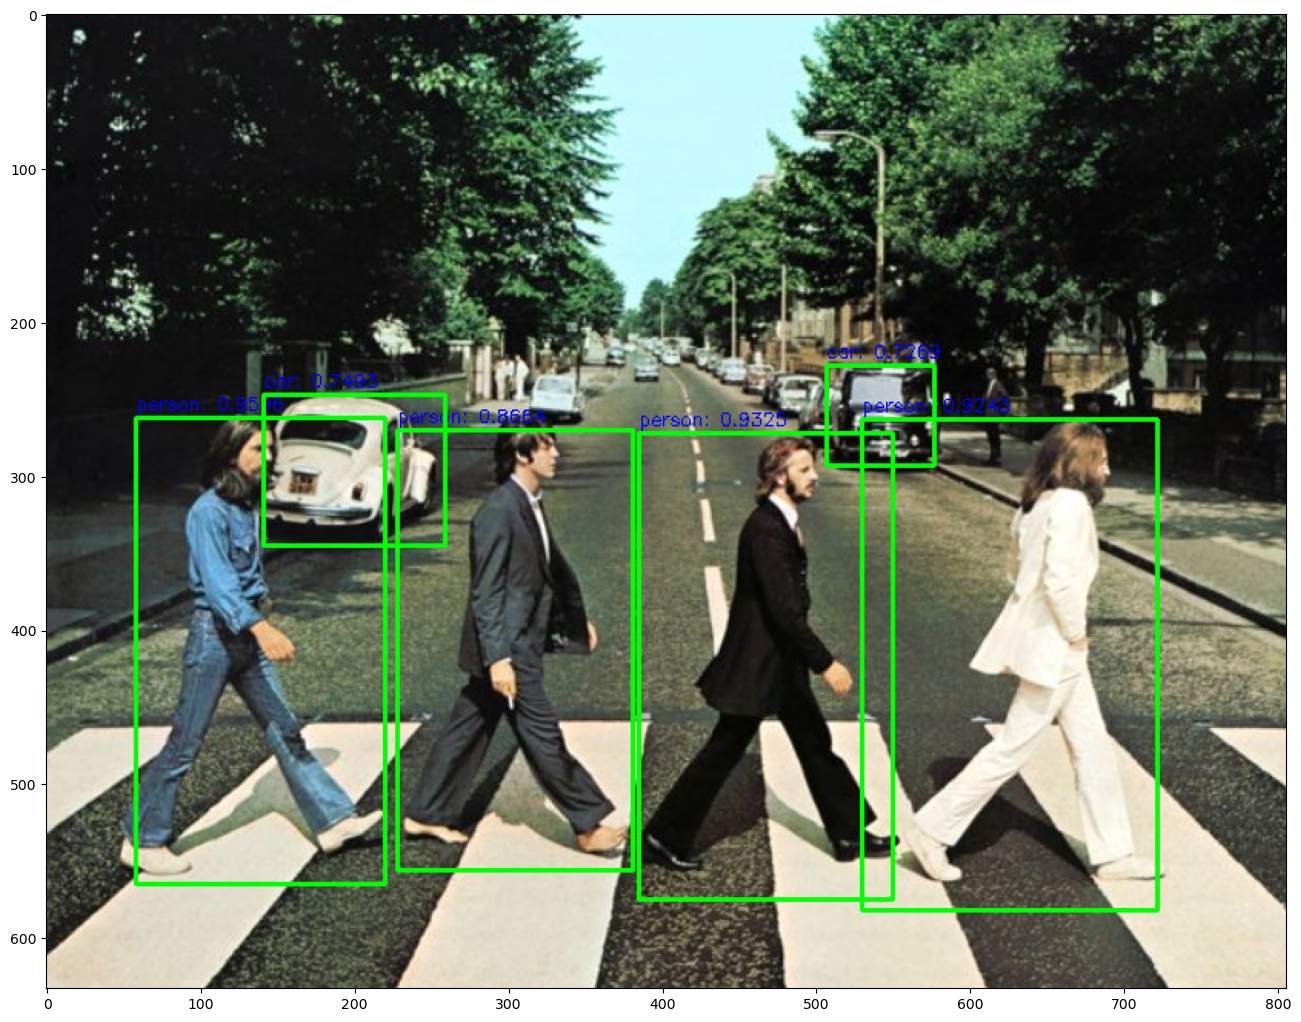

In [26]:
import cv2
img_array = cv2.cvtColor(cv2.imread('../data/beatles01.jpg'), cv2.COLOR_BGR2RGB)

draw_img = get_detected_img(export_model, img_array, is_print=True)
plt.figure(figsize=(16, 16))
plt.imshow(draw_img)